<font face='serif' size=4>
<span style="line-height: 1.25;">

# HW8 for Statistics with Meteorological Application
---
Student: 林之然 (B11209005, 大氣二), 蔡知諺（B11209014, 大氣二）

<font face='serif' size=4>
<span style="line-height: 1.25;">

### HW 8.1 What is the role of Logistic Regression in the excerpted article (Wu et al. (2022))
Answer:
The Logistic Regression model is used as a baseline to evaluate whether the ANN model is better in identifying SSW events.



<font face='serif' size=4>
<span style="line-height: 1.25;">

### HW 8.2 Use logistic regression to classify SSW
**(Implemented in following cell)**

#### Introduction
In this homework we're asked to train a logistic regression model to identify the SSW events by zonal wind profiles at 10 hPa, 60 ºN. The model is trained by 70% of the data and tested by the remained 30% data. 

#### Model Modification
Based on the given code, we've modified the structure and some hyperparameters to improve the accuracy of the model. The model originally had an input layer with size 144 and a output layer with size 1 (binary classification). In the new structure (see figure below), two hidden layers with size 64 and 32 were added. What's more, we also changed the value of the hyperparameters to reach a higher accuracy (we got 100% as shown later).

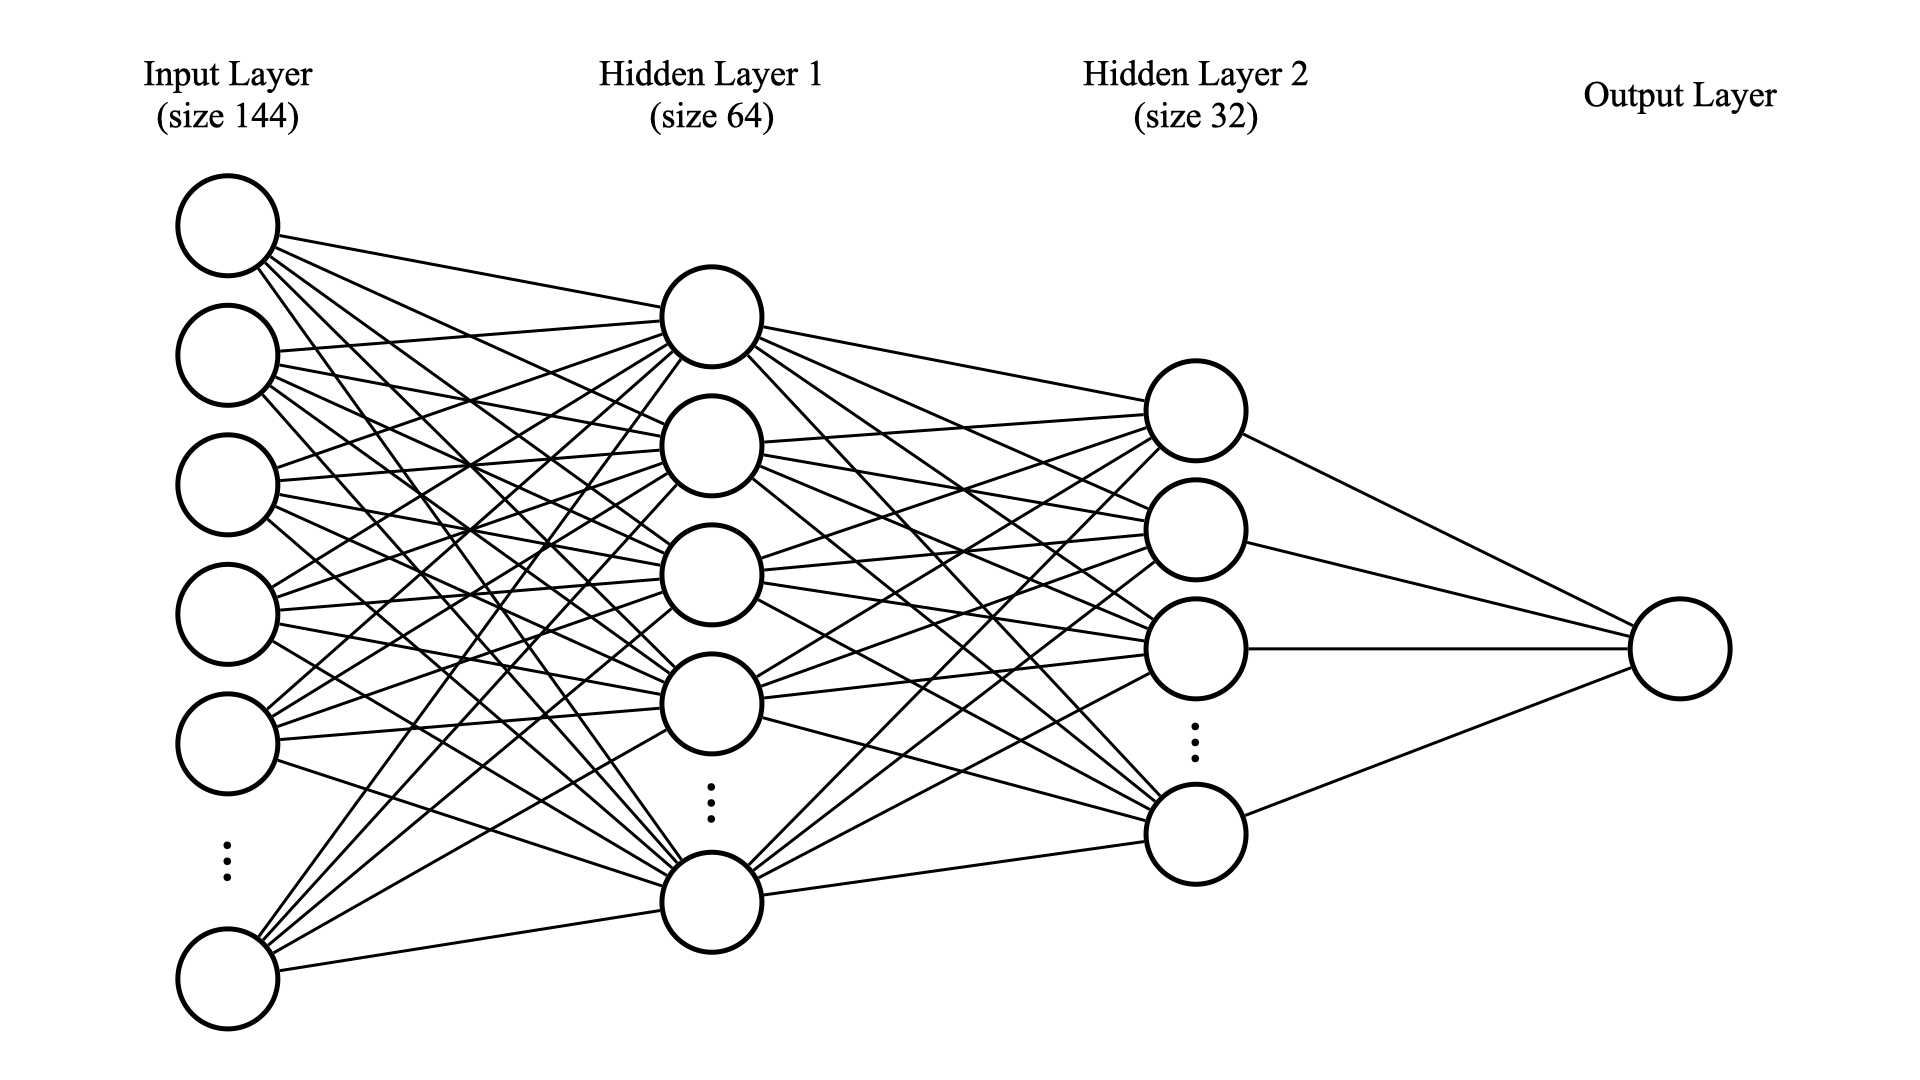

#### Data Visualization

The visualizations of the wind speed data reveal distinct patterns and variations across the features and samples. The **line chart**, which plots the feature values for the first ten samples, illustrates how wind speeds vary across different longitudes, highlighting both similarities and differences among the samples. The **heatmap** provides a comprehensive overview of the dataset, with color intensity indicating the magnitude of wind speeds; this visualization helps in identifying consistent patterns and anomalies across all samples and features. Finally, the **single sample chart** offers a detailed view of an individual sample's wind speed distribution, showing how a particular sample's feature values fluctuate. Together, these visualizations offer a clear and insightful representation of the wind speed data, aiding in understanding its overall distribution and specific characteristics.

#### Demonstrate the performance
By fixing the random seed, we ensure reproducibility of the training outcomes in each run. In our modified model, the accuracy consistently reaches 100%, and the loss decreases to below 0.05 within 20 epochs for both the training and testing sets.

![performance.png](performance.png)


<font face='serif' size=4>
<span style="line-height: 1.25;">

### Belows are the codes of the model
---

#### Import necessary packages

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import logging

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Check cuda is avaliable

In [297]:
# Check mps is available
try: device = torch.device("mps")
except: device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Training data visualization

The visualizations of the wind speed data reveal distinct patterns and variations across the features and samples. The line chart, which plots the feature values for the first ten samples, illustrates how wind speeds vary across different longitudes, highlighting both similarities and differences among the samples. The heatmap provides a comprehensive overview of the dataset, with color intensity indicating the magnitude of wind speeds; this visualization helps in identifying consistent patterns and anomalies across all samples and features. Finally, the single sample chart offers a detailed view of an individual sample's wind speed distribution, showing how a particular sample's feature values fluctuate. Together, these visualizations offer a clear and insightful representation of the wind speed data, aiding in understanding its overall distribution and specific characteristics.

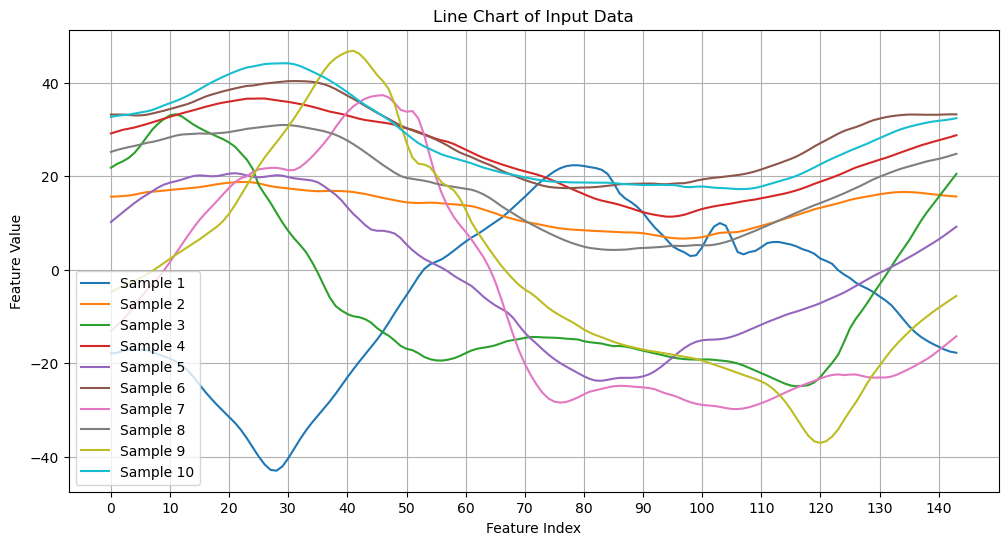

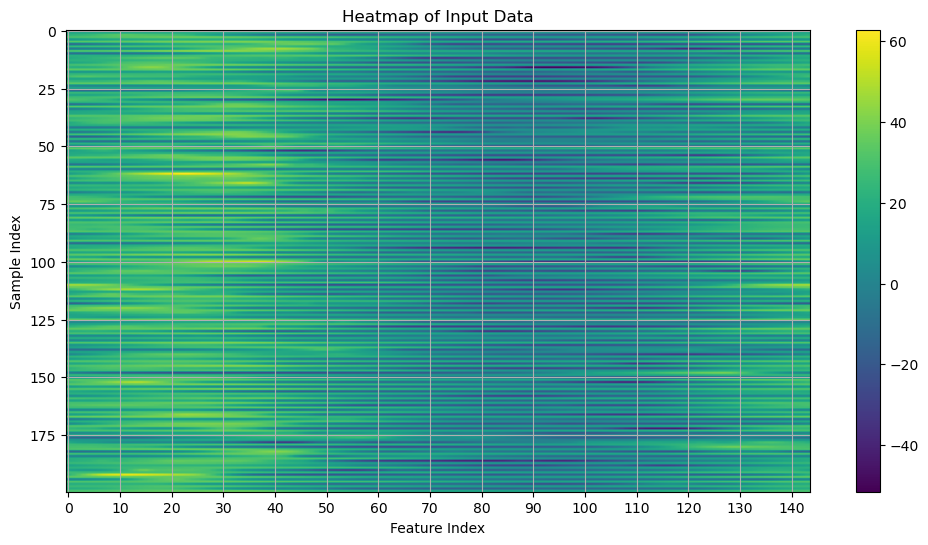

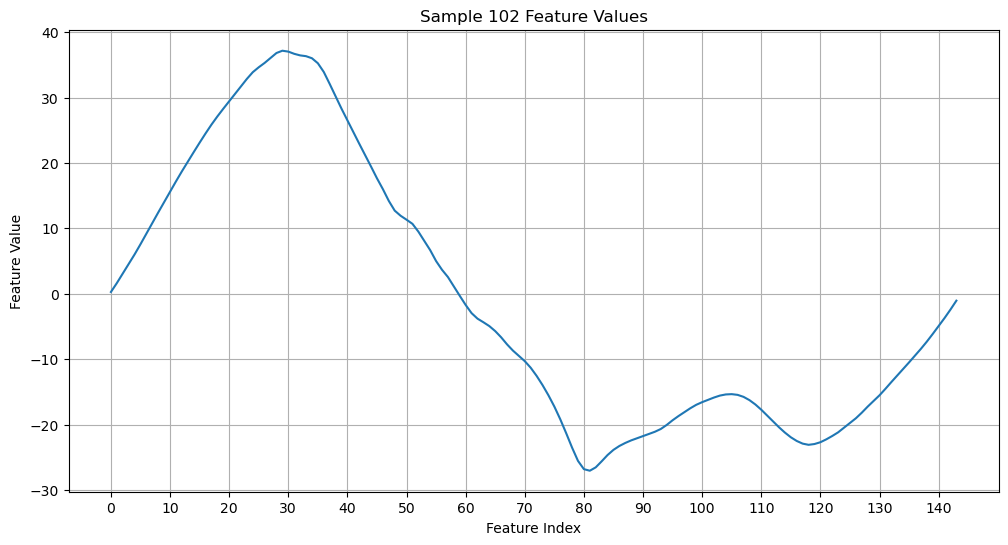

In [298]:
# Read the input data
dfx = pd.read_csv('./hw10_u_x.csv', skiprows=0)

# Drop the first column
dfx = dfx.drop(columns=['Unnamed: 0'])

# Visualize the input data
def plot_line_chart(data):
    plt.figure(figsize=(12, 6))
    for i in range(min(len(data), 10)):
        plt.plot(data.iloc[i], label=f'Sample {i+1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('Line Chart of Input Data')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.legend()
    plt.grid()
    plt.show()

def plot_heatmap(data):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title('Heatmap of Input Data')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.grid()
    plt.show()

def plot_sample(data, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[sample_index])
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title(f'Sample {sample_index} Feature Values')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.grid()
    plt.show()

# Plot the line chart, heatmap, and a random sample
plot_line_chart(dfx)
plot_heatmap(dfx)
plot_sample(dfx, sample_index=np.random.randint(len(dfx)))

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Define functions

In [299]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()

    return np

class LogisticRegression(nn.Module):
    """
    Neural Network model with multiple hidden layers.

    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of neurons in each hidden layer.
        output_size (int): The number of output classes.

    Attributes:
        fc1 (nn.Linear): The first fully connected layer.
        fc2 (nn.Linear): The second fully connected layer.
        fc3 (nn.Linear): The output layer.

    Methods:
        forward(x): Performs forward pass through the model.

    """

    def __init__(self, input_size, hidden_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        """
        Performs forward pass through the model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.

        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def train(model, x, y, optimizer):
    """
    Trains the given model using the provided input data and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained.
        x (torch.Tensor): The input data.
        y (torch.Tensor): The target labels.
        optimizer (torch.optim.Optimizer): The optimizer used for training.

    Returns:
        tuple: A tuple containing the loss and the output of the model.
    """
    x, y = x.to(device), y.to(device)
    model.zero_grad()  # Set gradients of all model parameters to zero
    output = model(x)
    output = torch.squeeze(output)
    loss = F.binary_cross_entropy(output, y)
    loss.backward()
    optimizer.step()

    return loss, output

def test(model, x, y):
    x, y = x.to(device), y.to(device)
    model.eval()  # switch model to evaluate mode
    output = model(x)
    output = torch.squeeze(output)
    loss = F.binary_cross_entropy(output, y)

    return loss, output

def calculate_accuracy(y_true, y_pred):
    y_true, y_pred = y_true.to(device), y_pred.to(device)
    predicted = y_pred.ge(.5).view(-1)
    err_num = (y_true != predicted).sum()
    accuracy = (y_true == predicted).sum().float()/len(y_true)

    return err_num, accuracy

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Load data and transform into tensor

Data: zonal wind at 10hPa, 60 deg N

In [300]:
# Fix the random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load the data
path = './'
dfx = pd.read_csv(path+'hw10_u_x.csv', skiprows=0, usecols=np.arange(1,145)) # cases(200) x lon(144)
dfy = pd.read_csv(path+'hw10_u_y.csv', skiprows=0, usecols=[1]) # 200 x 1
x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.3, random_state=seed)  # 70% training and 30% test

# convert all fields to Tensors
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape,'y_test:',  y_test.shape)

lon = np.linspace(0,358.75,144)

x_train: torch.Size([140, 144]) y_train: torch.Size([140])
x_test: torch.Size([60, 144]) y_test: torch.Size([60])


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Hyperparameters and configurations

In [301]:
# hyperparameters
input_size  = 144  # number of features
hidden_size = 64  # number of hidden units
output_size = 1  # binary classification
EPOCHS      = 20  # number of epochs
lr          = 1e-2  # learning rate
wd          = 1e-5  # weight decay

# model
model_logreg = LogisticRegression(input_size, hidden_size, output_size)
model_logreg.to(device)

# optimizer: stochastic gradient descent
optimizer = optim.SGD(model_logreg.parameters(), lr=lr, weight_decay=wd)  # weight_decay is L2 regularization
Accuracy = np.zeros((EPOCHS, 2))  # epochs, train/test
Loss = np.zeros((EPOCHS, 2))  # epochs, train/test

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Training loop

The output log is in `hw8_training.log`.


In [302]:
# Use tqdm to show the progress bar
start_time = time.time()
logging.basicConfig(filename='hw8_training.log', level=logging.INFO)
for epoch in tqdm(range(EPOCHS), desc='Training progress'):
    x_train = x_train.view(-1, 144)
    x_train, y_train = x_train.to(device), y_train.to(device)
    train_loss, train_pred = train(model_logreg, x_train, y_train, optimizer)
    train_errnum, train_acc = calculate_accuracy(y_train, train_pred)
    test_loss, test_pred = test(model_logreg, x_test, y_test)
    test_errnum, test_acc = calculate_accuracy(y_test, test_pred)
    
    message = 'Epoch {}\n'.format(epoch+1)
    message += '     Train set - loss: {}\n'.format(train_loss)
    message += '     Train set - accuracy: {}\n'.format(train_acc)
    message += '     Test set - loss: {}\n'.format(test_loss)
    message += '     Test set - accuracy: {}\n'.format(test_acc)
    message += '     Number of test errors: {}\n'.format(test_errnum)
    
    # Write the message to th log file
    logging.info(message)
    
    Accuracy[epoch,0], Accuracy[epoch,1] = train_acc, test_acc
    Loss[epoch,0], Loss[epoch,1] = train_loss, test_loss

# Calculate total training time
train_time = time.time() - start_time
print(f'Training time for {EPOCHS} epochs: {train_time:.2f} seconds')

Training progress: 100%|██████████| 20/20 [00:00<00:00, 160.98it/s]

Training time for 20 epochs: 0.13 seconds


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Plot the results

By fixing the random seed, we ensure reproducibility of the training outcomes in each run. In our modified model, the accuracy consistently reaches 100%, and the loss decreases to below 0.05 within 20 epochs for both the training and testing sets.

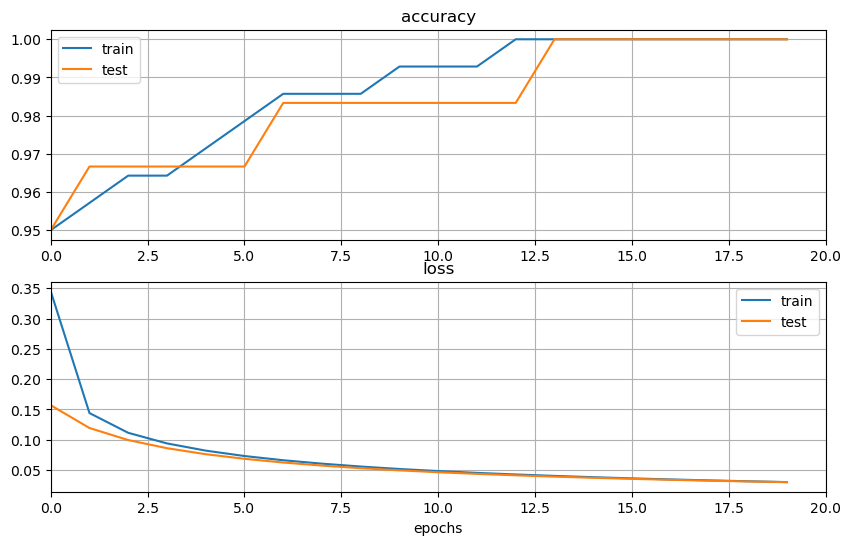

In [303]:
# plot accuracy
plt.close('all')
fig = plt.figure(figsize=(10, 6))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
ax0.plot(np.arange(0,EPOCHS), Accuracy[:,0], label='train')
ax0.plot(np.arange(0,EPOCHS), Accuracy[:,1], label='test')
#ax0.set_xscale('log')
ax0.legend()
ax0.title.set_text('accuracy')
ax0.grid()
ax0.set_xlim([0,EPOCHS])

# plot loss
ax1.plot(np.arange(0,EPOCHS), Loss[:,0], label='train')
ax1.plot(np.arange(0,EPOCHS), Loss[:,1], label='test')
#ax1.set_xscale('log')
ax1.legend()
ax1.title.set_text('loss')
ax1.set_xlabel('epochs')
ax1.grid()
ax1.set_xlim([0,EPOCHS])

plt.show()

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### cf. Comparasion on CPU and MPS
We utilize Pytorch's Metal Performance Shaders (mps) backend (which runs on the GPUs) and compare the efficiency with the CPU. 

In [304]:
# Function to measure time
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Measure CPU time
device = torch.device("cpu")
model_logreg.to(device)
train_time_cpu = []
test_time_cpu = []
for epoch in tqdm(range(EPOCHS), desc='Training on CPU'):
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    _, train_time = measure_time(train, model_logreg, x_train, y_train, optimizer)
    _, test_time = measure_time(test, model_logreg, x_test, y_test)
    train_time_cpu.append(train_time)
    test_time_cpu.append(test_time)

print(f"Average train time on CPU: {np.mean(train_time_cpu):.4f} seconds")
print(f"Average test time on CPU: {np.mean(test_time_cpu):.4f} seconds")

# Measure MPS time
device = torch.device("mps")
model_logreg.to(device)
train_time_mps = []
test_time_mps = []
for epoch in tqdm(range(EPOCHS), desc='Training on MPS'):
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    _, train_time = measure_time(train, model_logreg, x_train, y_train, optimizer)
    _, test_time = measure_time(test, model_logreg, x_test, y_test)
    train_time_mps.append(train_time)
    test_time_mps.append(test_time)

print(f"Average train time on MPS: {np.mean(train_time_mps):.4f} seconds")
print(f"Average test time on MPS: {np.mean(test_time_mps):.4f} seconds")


Training on CPU: 100%|██████████| 20/20 [00:00<00:00, 3006.99it/s]


Average train time on CPU: 0.0002 seconds
Average test time on CPU: 0.0001 seconds


Training on MPS: 100%|██████████| 20/20 [00:00<00:00, 579.80it/s]

Average train time on MPS: 0.0013 seconds
Average test time on MPS: 0.0003 seconds
